In [38]:
import os.path as osp
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid, WebKB, HeterophilousGraphDataset
# from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj

from FormanRicci import FormanRicci

dataset_name = 'Cora'
hidden_channels = 8
heads = 1
lr = 0.005
epochs =200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#init_wandb(name=f'GAT-{args.dataset}', heads=args.heads, epochs=args.epochs,
#           hidden_channels=args.hidden_channels, lr=args.lr, device=device)

dataset = Planetoid(root="data", name=dataset_name)
data = dataset[0].to(device)

In [39]:
"""
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        attention_scores_1 = self.conv1(x, edge_index, return_attention_weights=True)[1]
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        attention_scores_2 = self.conv2(x, edge_index, return_attention_weights=True)[1]
        x = self.conv2(x, edge_index)
        return x, attention_scores_1, attention_scores_2

"""
# 4-layer GAT

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)
        
        # Add a third convolutional layer
        self.conv3 = GATConv(out_channels, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        attention_scores_1 = self.conv1(x, edge_index, return_attention_weights=True)[1]
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        attention_scores_2 = self.conv2(x, edge_index, return_attention_weights=True)[1]
        x = self.conv2(x, edge_index)
        attention_scores_3 = self.conv3(x, edge_index, return_attention_weights=True)[1]
        x = F.elu(self.conv3(x, edge_index))
        attention_scores_4 = self.conv3(x, edge_index, return_attention_weights=True)[1]
        x = F.elu(self.conv3(x, edge_index))
        
        return x, attention_scores_1, attention_scores_2, attention_scores_3, attention_scores_4


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[0]
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index)[0].argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [40]:
model = GAT(dataset.num_features, hidden_channels, dataset.num_classes,
            heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

times = []
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    # print("Train Acc: ", train_acc, "Val Acc: ", val_acc, "Test Acc: ", tmp_test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    # log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Median time per epoch: 0.0162s


In [41]:
pred, attention_scores_1, attention_scores_2, attention_scores_3, attention_scores_4 = model(data.x, data.edge_index)

In [11]:
G = to_networkx(dataset[0])

In [42]:
print("Num. nodes:", len(G.nodes()))

print("Num. edges:", len(G.edges()))

print("All edges in computation graph:", len(G.edges()) + len(G.nodes()))

Num. nodes: 2708
Num. edges: 10556
All edges in computation graph: 13264


In [53]:
"""
- attention_scores_1 is a tuple with all the edges contained in attention_scores_1[0]

- attention_scores_1[0] is a PyTorch tensor with shape [2, 13264] (2 nodes make up one edge)

- attention_scores_1[1] is a PyTorch tensor with shape [13264, 8], where 8 is the number of attention heads
"""

attention_scores_1[0][1]

tensor([ 633, 1862, 2582,  ..., 2705, 2706, 2707], device='cuda:0')

In [10]:
# sum over multiple attention heads

attention_1_list = [sum(item).detach().numpy() for item in attention_scores_1[1].cpu()][:len(G.edges)]

In [23]:
# assume we only have one attention head

attention_4_list = [item[0].detach().numpy() for item in attention_scores_4[1].cpu()][:len(G.edges)]

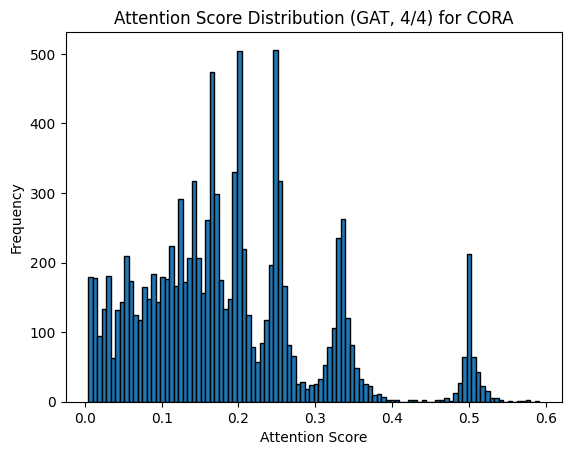

In [25]:
# Create a histogram
plt.hist(attention_4_list, bins=100, edgecolor='black')  # Adjust the number of bins as needed

# Add labels and a title
plt.xlabel('Attention Score')
plt.ylabel('Frequency')
plt.title('Attention Score Distribution (GAT, 4/4) for CORA')

# Show the plot
plt.show()

In [3]:
afrc = FormanRicci(G)
afrc.compute_ricci_curvature()
_C = sorted(afrc.G.edges, key=lambda x: afrc.G[x[0]][x[1]]['AFRC'])

In [4]:
curvature_values = [afrc.G[edge[0]][edge[1]]['AFRC'] for edge in _C]

In [17]:
# Compute correlation between attention and ORC

from GraphRicciCurvature.OllivierRicci import OllivierRicci

orc_values = []

orc = OllivierRicci(G, alpha=0.5, verbose="ERROR")
orc.compute_ricci_curvature()

In [18]:
for i in range(len(attention_2_list)):
    u = attention_scores_2[0][0][i].cpu().item()
    v = attention_scores_2[0][1][i].cpu().item()
    orc_values.append(orc.G.edges[u, v]["ricciCurvature"])

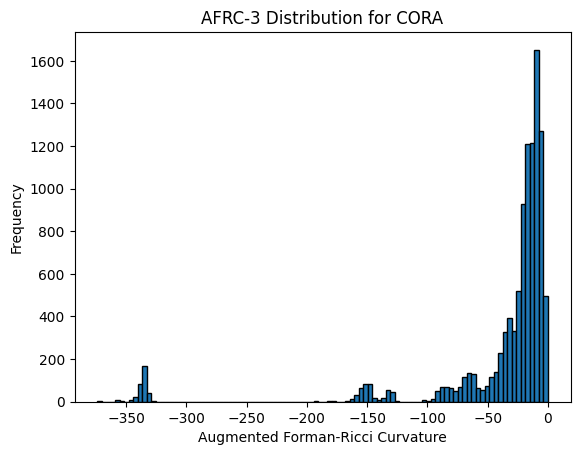

In [6]:
# Create a histogram
plt.hist(curvature_values, bins=100, edgecolor='black')  # Adjust the number of bins as needed

# Add labels and a title
plt.xlabel('Augmented Forman-Ricci Curvature')
plt.ylabel('Frequency')
plt.title('AFRC-3 Distribution for CORA')

# Show the plot
plt.show()

In [21]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(attention_3_list, curvature_values)

print("Pearson correlation coefficient:", correlation_coefficient)
print("P Value:", p_value)

Pearson correlation coefficient: -0.001377833082498199
P Value: 0.8874392742149991
